### Explorations for Zillow Project


Does the lot size affect the value of the house?
Should I combine bathroom/bedroom count

Counties by FIP:
    6037 - Los Angeles County
    6059 - Orange County
    6111 - Ventura County
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from scipy import stats

import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, QuantileTransformer
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE

# Import created modules
import env
import acquire
import wrangle_zillow

# Clear pink warning boxes
import warnings
warnings.filterwarnings("ignore")

# Handle large numbers w/o using scientific notation
pd.options.display.float_format = '{:.3f}'.format

### ```Acquire Data```

In [2]:
df = wrangle_zillow.acquire('zillow')
df.head()

,bathroomcnt,bedroomcnt,yearbuilt,calculatedfinishedsquarefeet,lotsizesquarefeet,parcelid,fips,regionidzip,taxvaluedollarcnt,taxamount
0,2.000,3.000,1923.000,1316.000,5672.000,11721753,6037.000,95997.000,205123.000,2627.480
1,2.000,3.000,1970.000,1458.000,8284.000,11289917,6037.000,97318.000,136104.000,2319.900
2,2.000,3.000,1980.000,1766.000,25082.000,11637029,6037.000,96086.000,810694.000,9407.010
3,1.000,2.000,1911.000,1421.000,6707.000,11705026,6037.000,96018.000,35606.000,543.690
4,3.000,4.000,2003.000,2541.000,4975.000,14269464,6059.000,96958.000,880456.000,9819.720


In [3]:
print(f'My original dataframe is coming in with {df.shape[0]} rows and {df.shape[ 1]} columns.')

My original dataframe is coming in with 34356 rows and 10 columns.


### ```Prepare Data```

In [4]:
df = wrangle_zillow.prep_zillow(df)
df.head()

,bathrooms,bedrooms,age,square_feet,lot_size,fips,zip_code,tax_value,taxes
parcel_id,,,,,,,,,
11721753,2,3,94,1316,5672,6037,95997,205123.000,2627.480
11289917,2,3,47,1458,8284,6037,97318,136104.000,2319.900
11637029,2,3,37,1766,25082,6037,96086,810694.000,9407.010
11705026,1,2,106,1421,6707,6037,96018,35606.000,543.690
14269464,3,4,14,2541,4975,6059,96958,880456.000,9819.720


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34356 entries, 11721753 to 10713993
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bathrooms    34356 non-null  int64  
 1   bedrooms     34356 non-null  int64  
 2   age          34356 non-null  int64  
 3   square_feet  34356 non-null  int64  
 4   lot_size     34356 non-null  int64  
 5   fips         34356 non-null  int64  
 6   zip_code     34356 non-null  int64  
 7   tax_value    34356 non-null  float64
 8   taxes        34356 non-null  float64
dtypes: float64(2), int64(7)
memory usage: 2.6 MB


In [6]:
df.shape

(34356, 9)

In [7]:
df.columns

Index(['bathrooms', 'bedrooms', 'age', 'square_feet', 'lot_size', 'fips',
       'zip_code', 'tax_value', 'taxes'],
      dtype='object')

In [8]:
df.describe()

,bathrooms,bedrooms,age,square_feet,lot_size,fips,zip_code,tax_value,taxes
count,34356.000,34356.000,34356.000,34356.000,34356.000,34356.000,34356.000,34356.000,34356.000
mean,2.271,3.136,49.707,1830.480,29997.904,6047.143,96515.227,506950.720,6185.201
std,0.950,0.983,22.686,948.691,111697.595,19.768,404.388,646693.924,7503.007
min,1.000,1.000,1.000,242.000,236.000,6037.000,95982.000,1000.000,51.260
25%,2.000,2.000,32.000,1219.000,5841.750,6037.000,96193.000,205281.500,2735.720
50%,2.000,3.000,51.000,1585.000,7319.000,6037.000,96377.000,368134.000,4584.145
75%,3.000,4.000,64.000,2179.250,12192.000,6059.000,96978.000,599000.000,7175.625
max,11.000,11.000,139.000,17245.000,6971010.000,6111.000,97344.000,23858374.000,276797.830


In [9]:
#I see an error in zipcodes -- the max value is six digits
zip_check = pd.DataFrame(df.zip_code > 99999)
zip_check.value_counts("zip_code")

zip_wrong = pd.DataFrame(df.zip_code == True)
zip_wrong                         
               


,zip_code
parcel_id,
11721753,False
11289917,False
11637029,False
11705026,False
14269464,False
...,...
14453399,False
12019061,False
11570288,False


In [10]:
df.isna().sum() 

bathrooms      0
bedrooms       0
age            0
square_feet    0
lot_size       0
fips           0
zip_code       0
tax_value      0
taxes          0
dtype: int64

In [11]:
df.bathrooms.value_counts(dropna=False)

2     16590
3      8981
1      6195
4      1708
5       580
6       202
7        63
8        30
9         4
11        2
10        1
Name: bathrooms, dtype: int64

In [12]:
df.bedrooms.value_counts(dropna=False)

3     14439
4      8720
2      7468
5      2190
1      1130
6       344
7        51
8         7
9         4
10        2
11        1
Name: bedrooms, dtype: int64

In [13]:
df.age.value_counts(dropna=False)

62     1016
67      878
53      825
64      795
63      782
       ... 
123       1
125       1
1         1
132       1
137       1
Name: age, Length: 131, dtype: int64

In [14]:
df.square_feet.value_counts(dropna=False)

1120    84
1200    79
1080    64
864     61
1040    59
        ..
4100     1
3757     1
4068     1
5806     1
3976     1
Name: square_feet, Length: 4142, dtype: int64

In [15]:
df.lot_size.value_counts(dropna=False)

6000     475
5000     231
7200     183
7000     159
6500     149
        ... 
82042      1
22649      1
20600      1
8310       1
10357      1
Name: lot_size, Length: 13538, dtype: int64

In [16]:
df.fips.value_counts(dropna=False)

6037    24224
6059     7717
6111     2415
Name: fips, dtype: int64

In [17]:
df.zip_code.value_counts(dropna=False)

97319    426
97318    340
97329    299
97118    290
97328    288
        ... 
95995      3
96002      2
97108      2
96467      1
96039      1
Name: zip_code, Length: 382, dtype: int64

In [18]:
df.tax_value.value_counts(dropna=False)


420000.000     22
550000.000     22
450000.000     19
430000.000     18
455000.000     18
               ..
55867.000       1
1525607.000     1
631735.000      1
414172.000      1
245760.000      1
Name: tax_value, Length: 26273, dtype: int64

In [19]:
df.taxes.value_counts(dropna=False)

2388.630     4
3297.910     3
2418.220     3
3509.140     3
2839.260     3
            ..
1186.040     1
4186.990     1
7570.330     1
10127.700    1
5632.000     1
Name: taxes, Length: 33678, dtype: int64

### ```Split Data```

In [20]:
 print(f'My original dataframe is coming in with {df.shape[0]} rows and {df.shape[ 1]} columns.')

My original dataframe is coming in with 34356 rows and 9 columns.


In [21]:
X_train, X_validate, X_test, y_train, y_validate, y_test = wrangle_zillow.train_validate_test_split(df, 'tax_value')

In [22]:
X_train.shape, X_validate.shape, X_test.shape

((19238, 8), (8246, 8), (6872, 8))

In [23]:
y_train.shape, y_validate.shape, y_test.shape

((19238,), (8246,), (6872,))

In [24]:
X_train.head()

,bathrooms,bedrooms,age,square_feet,lot_size,fips,zip_code,taxes
parcel_id,,,,,,,,
11008335,3,3,30,2051,16993,6037,96368,5770.850
12625763,1,1,36,750,121951,6037,96228,1648.830
12312945,1,2,78,974,4984,6037,96125,4672.380
14167439,2,4,47,1562,7335,6059,97078,7344.740
12651712,1,3,66,1422,6074,6037,96221,1009.740


### ```Scale Data```

In [25]:
# Scale the data using MinMaxScaler function

num_cols = ['bedrooms','bathrooms','age','square_feet', 'lot_size','zip_code', 'taxes', 'fips']
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle_zillow.min_max_scale(X_train, X_validate, X_test, num_cols)

X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((19238, 8), (8246, 8), (6872, 8))

### ```Explore Data```

array([[<AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'square_feet'}>,
        <AxesSubplot:title={'center':'lot_size'}>,
        <AxesSubplot:title={'center':'fips'}>],
       [<AxesSubplot:title={'center':'zip_code'}>,
        <AxesSubplot:title={'center':'tax_value'}>,
        <AxesSubplot:title={'center':'taxes'}>]], dtype=object)

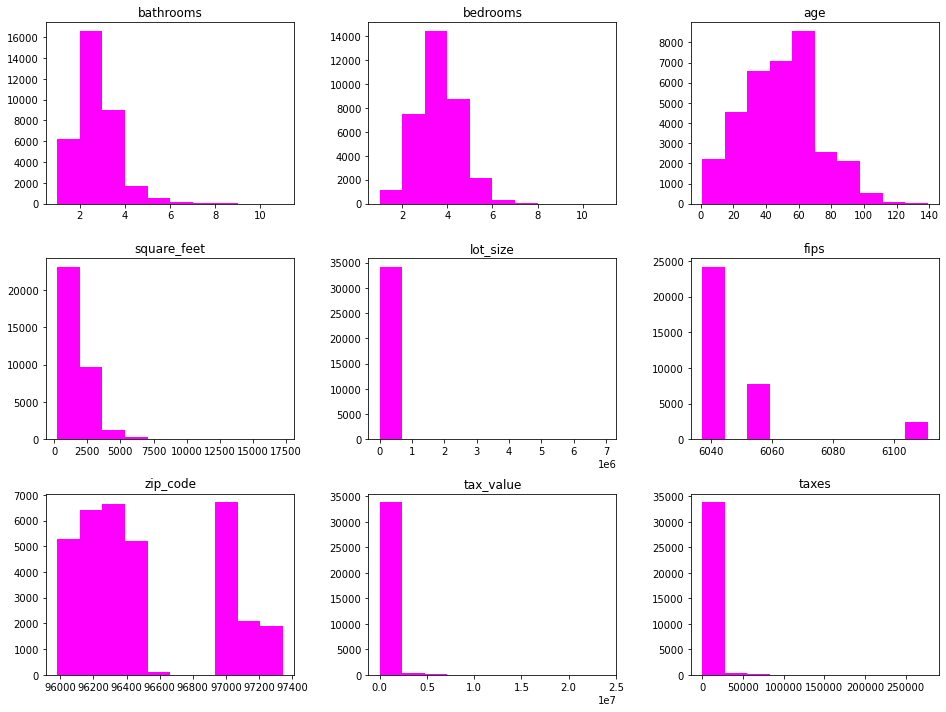

In [26]:
#Exploring distribution of all numeric columns in entire df

df.hist(grid=False, figsize=(16,12), color='magenta')

<AxesSubplot:xlabel='fips', ylabel='Density'>

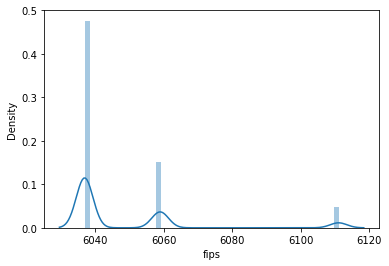

In [27]:
#Create a distplot to explore the distribution of Pandas Series

sns.distplot(df.fips)

<AxesSubplot:>

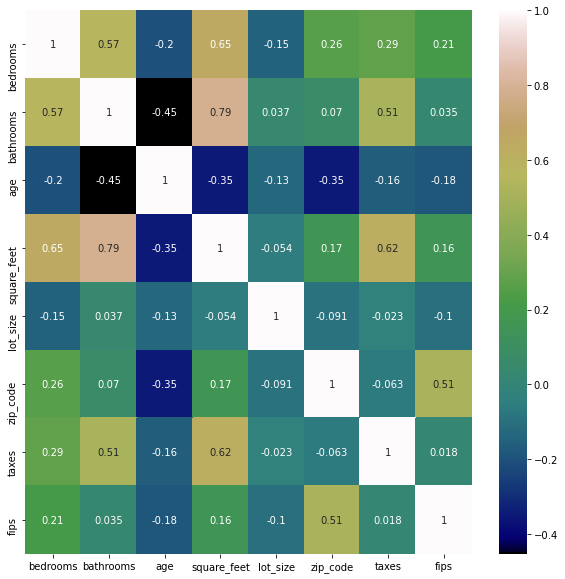

In [28]:

plt.subplots(figsize=(10,10))
sns.heatmap(X_train_scaled.corr(), cmap='gist_earth',annot=True)

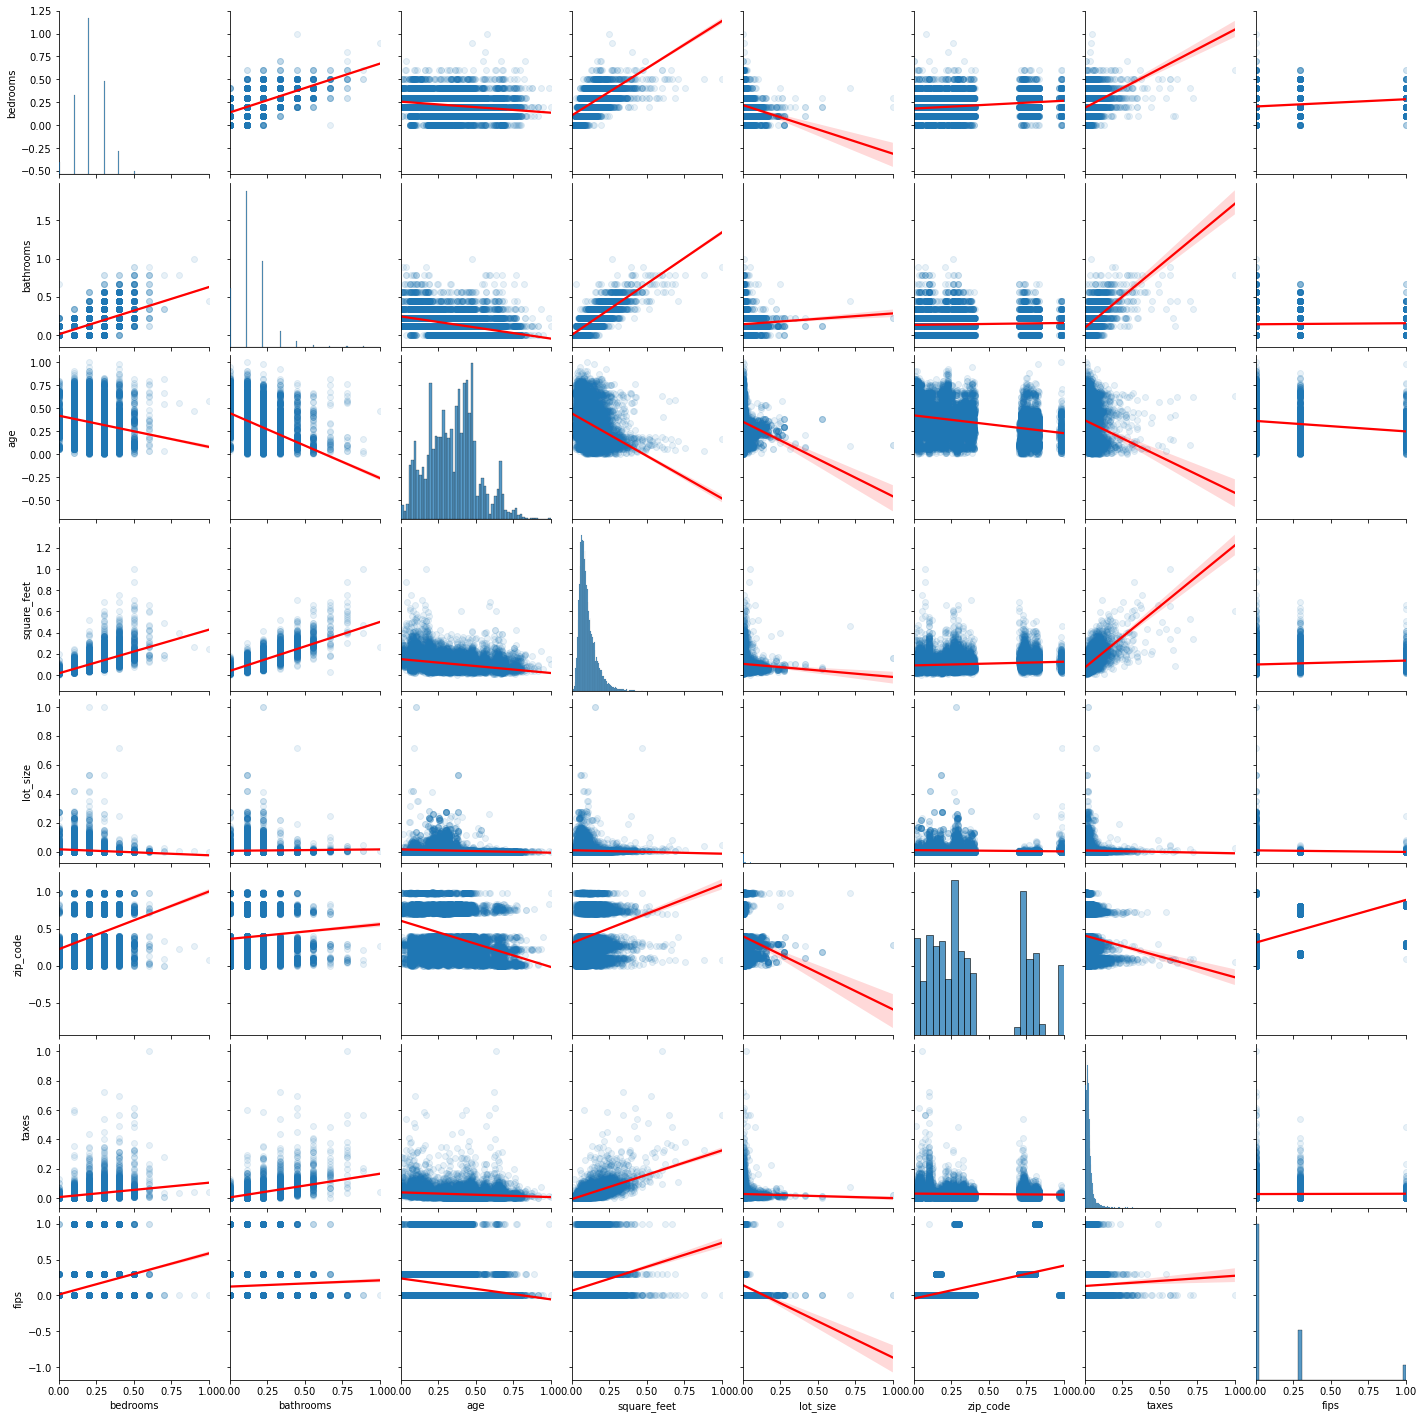

In [29]:
plot_kws={'line_kws':{'color':'red'},'scatter_kws': {'alpha': 0.7}}    
sns.pairplot(X_train_scaled, kind="reg", plot_kws={'line_kws':{'color':'red'},'scatter_kws': {'alpha': 0.1} })


The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.57


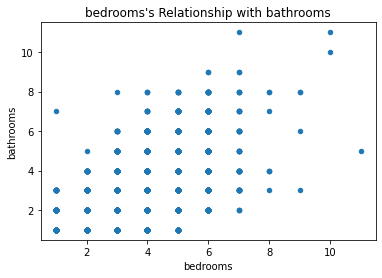

In [30]:
def correlation_exploration(train, x_string, y_string):
    '''
    This function takes in a df, a string for an x-axis variable in the df, 
    and a string for a y-axis variable in the df and displays a scatter plot, the r-
    squared value, and the p-value. It explores the correlation between input the x 
    and y variables.
    '''
    r, p = stats.pearsonr(train[x_string], train[y_string])
    df.plot.scatter(x_string, y_string)
    plt.title(f"{x_string}'s Relationship with {y_string}")
    print(f'The p-value is: {p}. There is {round(p,3)}% chance that we see these results by chance.')
    print(f'r = {round(r, 2)}')
    plt.show()
    
correlation_exploration(X_train_scaled, 'bedrooms', 'bathrooms')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.29


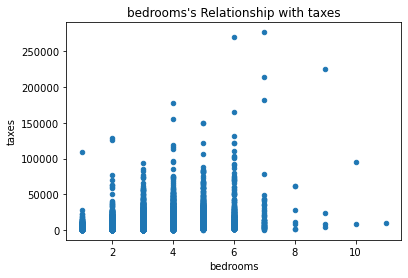

In [31]:
correlation_exploration(X_train, 'bedrooms', 'taxes')

The p-value is: 1.705449876630368e-18. There is 0.0% chance that we see these results by chance.
r = -0.06


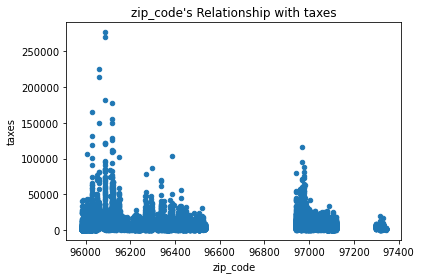

In [32]:
correlation_exploration(X_train, 'zip_code', 'taxes')

The p-value is: 0.012911769258585278. There is 0.013% chance that we see these results by chance.
r = 0.02


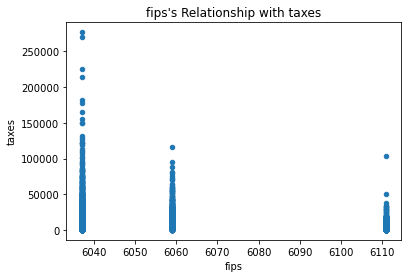

In [33]:
correlation_exploration(X_train, 'fips', 'taxes')

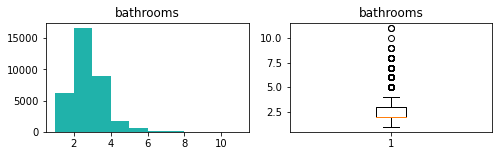

count   34356.000
mean        2.271
std         0.950
min         1.000
25%         2.000
50%         2.000
75%         3.000
max        11.000
Name: bathrooms, dtype: float64


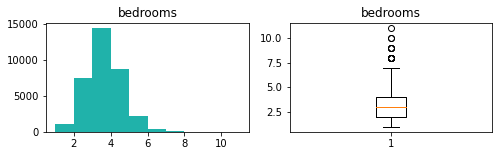

count   34356.000
mean        3.136
std         0.983
min         1.000
25%         2.000
50%         3.000
75%         4.000
max        11.000
Name: bedrooms, dtype: float64


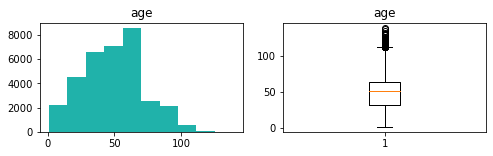

count   34356.000
mean       49.707
std        22.686
min         1.000
25%        32.000
50%        51.000
75%        64.000
max       139.000
Name: age, dtype: float64


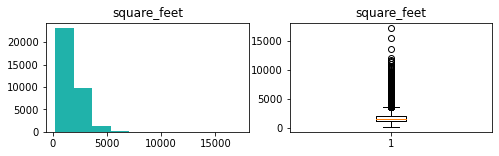

count   34356.000
mean     1830.480
std       948.691
min       242.000
25%      1219.000
50%      1585.000
75%      2179.250
max     17245.000
Name: square_feet, dtype: float64


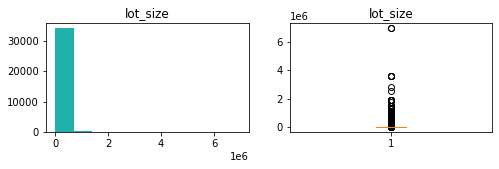

count     34356.000
mean      29997.904
std      111697.595
min         236.000
25%        5841.750
50%        7319.000
75%       12192.000
max     6971010.000
Name: lot_size, dtype: float64


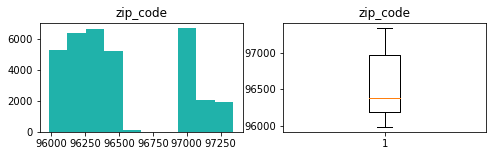

count   34356.000
mean    96515.227
std       404.388
min     95982.000
25%     96193.000
50%     96377.000
75%     96978.000
max     97344.000
Name: zip_code, dtype: float64


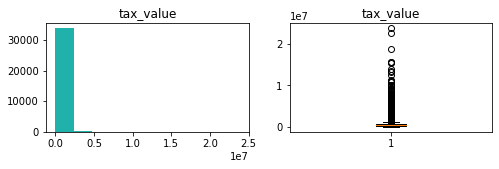

count      34356.000
mean      506950.720
std       646693.924
min         1000.000
25%       205281.500
50%       368134.000
75%       599000.000
max     23858374.000
Name: tax_value, dtype: float64


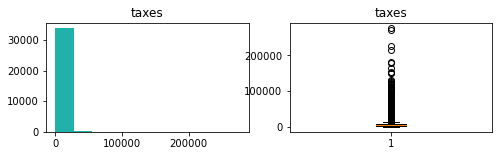

count    34356.000
mean      6185.201
std       7503.007
min         51.260
25%       2735.720
50%       4584.145
75%       7175.625
max     276797.830
Name: taxes, dtype: float64


In [34]:
# def plot_cat_by_target(train, target, cat_var):
#     p = plt.figure(figsize=(8,8))
#     p = sns.barplot(cat_var, target, data=train, alpha=.8, color='lightseagreen')
#     overall_rate = train[target].mean()
#     p = plt.axhline(overall_rate, ls='--', color='gray')
#     return p 

# plot_cat_by_target(df, df.tax_value, df.bedrooms)
cat_vars = []
quant_vars = ['bathrooms', 'bedrooms', 'age', 'square_feet', 'lot_size', 'zip_code', 'tax_value', 'taxes']
def explore_univariate_quant(train, quant_var):
    '''
    takes in a dataframe and a quantitative variable and returns
    descriptive stats table, histogram, and boxplot of the distributions. 
    '''
    descriptive_stats = train[quant_var].describe()
    plt.figure(figsize=(8,2))

    p = plt.subplot(1, 2, 1)
    p = plt.hist(train[quant_var], color='lightseagreen')
    p = plt.title(quant_var)

    # second plot: box plot
    p = plt.subplot(1, 2, 2)
    p = plt.boxplot(train[quant_var])
    p = plt.title(quant_var)
    return p, descriptive_stats

def explore_univariate(train, cat_vars, quant_vars):
    for var in cat_vars:
        explore_univariate_categorical(train, var)
        print('_________________________________________________________________')
    for col in quant_vars:
        p, descriptive_stats = explore_univariate_quant(train, col)
        plt.show(p)
        print(descriptive_stats)
        
explore_univariate(df, cat_vars, quant_vars)

### ```Create a Baseline```

In [35]:
# Make a copy of y_train dataframe, named ols_eval, with renamed column for actual value

ols_eval = y_train.copy()

ols_eval.rename(columns={'tax_value': 'actual'}, inplace=True)

TypeError: rename() got an unexpected keyword argument 'columns'

### ```Model Data - Explore```